# Radial mode regression

## Contents
* [Task description](#Task-description)
* [Dataset preprocessing](#Dataset-preprocessing)
* [Models architecture](#Models-architecture)
    * [1d model description](#1d-model-description)
    * [2d model description](#2d-model-description)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Models evaluation](#Model-evaluation)
    * [1d model evaluation](#1d-model-evaluation)
    * [2d model evaluation](#2d-model-evaluation)
* [Criticism](#criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further- development)

## Task description
To predict a position of the radial mode according to the pressure derivative vs time data.

## Dataset preprocessing

For training and model performance assessment we use pressure derivative from wells after GRP.

Dataset consists of two parts: train (311 items) and test (90 items).

Each one consists of:
* an array of the pressure derivative of different length
* an array of times when the above measurements were taken
* a type of a pattern determined by an expert for some of the itemes
* a well type
* a position of the radial mode

Some imports:

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(".."))

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, Pipeline, R, B, V, C, action, inbatch_parallel
from radial.batchflow.models.tf import TFModel
from radial.batchflow.models.tf.layers import conv_block

from radial.batchflow.research import Research, Option
from radial.batchflow.research.research import Executable

from radial.core import RadialBatch
from radial.core.radial_batch_tools import *

from research_utils import *
plt.style.use('ggplot')
%matplotlib inline

Dataset loading

In [2]:
train_data = Dataset(FilesIndex(path="./data_splited/train/*"), batch_class=RadialBatch)
test_data = Dataset(FilesIndex(path="./data_splited/test/*"), batch_class=RadialBatch)

We load data to an instance of Dataset class from Batchflow

In [3]:
sample_data = train_data.p.load(fmt='npz').next_batch(10)

Some examples of the initial data

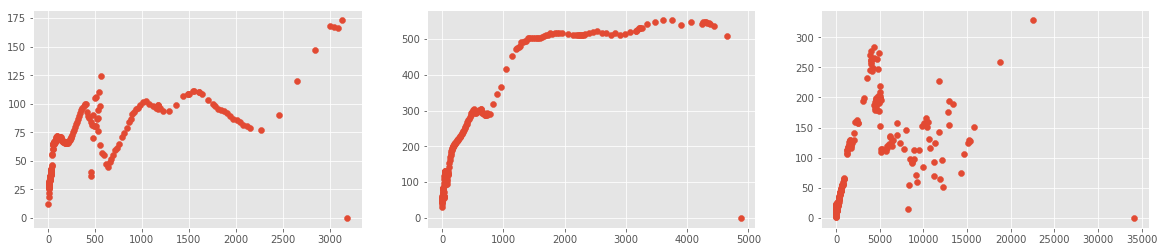

In [4]:
_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

Pressure derivative data is noisy so we denoised the data beforehand using unsupervised method [Isolation forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html). Сomparison of different approaches is [here](./denoising_esitmation.ipynb).

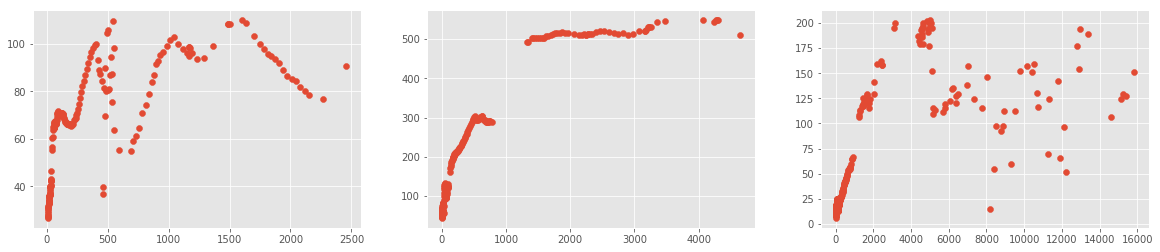

In [5]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/test_isol/*"), batch_class=RadialBatch)
sample_data = ds_train.p.load(fmt='npz').next_batch(10)

_, ax = plt.subplots(1, 3, figsize=(20, 4))
[ax[i].scatter(sample_data.time[i], sample_data.derivative[i]) for i in range(3)]
plt.show()

As you can see algorithm removed some of the single distant outliers that are not informative.

Distribution of radial mode value for train and test data:

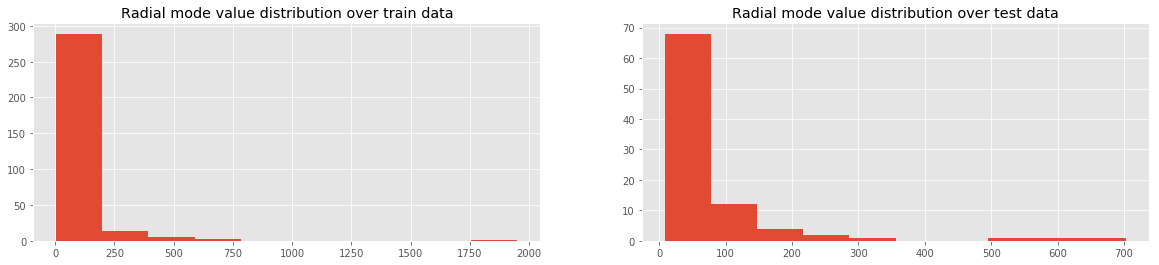

In [6]:
train = ds_train.p.load(fmt='npz').next_batch(len(ds_train))
test = ds_train.p.load(fmt='npz').next_batch(len(ds_test))

_, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].hist(train.target)
ax[0].set_title("Radial mode value distribution over train data")
ax[1].hist(test.target)
ax[1].set_title("Radial mode value distribution over test data")
plt.show()

Scale of the pressure derivative (and consequently the radial mode values) is different across different wells. Therefore in preprocessing pipeline we
normalize the pressure derivative data, time and radial mode value to the range [0, 1] by substracting min value and dividing by max-min.
Also we take logarithm of the pressure derivative, time and radial mode value and perform piece-wise interpolation to sample an equal number of points to feed the model.

## Models architecture

We use two approaches which differ in the input we feed to the model:
1. Input is the 1d array of the pressure derivative values of equal length parametrized by GRID_SIZE. In order to create an array of the fixed length from every well log data we perform piece-wise interpolation and take points on a uniform grid (i.e we take pressure derivative points at the fixed relative times).
2. Input is the 2d array of the time and corresponding pressure derivative values of equal shape (2, N_SAMPLES). We randomly sample time values from the uniform distribution and take corresponding pressure derivative values.

Next, consider a short description of the models.

### 1d model description

This is a convolutional neural network with 3 identical blocks.

The network architecture can be described by layout `cna cna cna Pf`, where letters correspond to the following layers:
* `с` - 1d convolution
* `n` - batch normalisation
* `a` - activation
* `P` - global average pooling
* `f` - dense

Convolutional layer parameters `c`:
* ```filters```= 64 * 2**i, where i - block number, i=0, 1, 2.
* ```kernel_size``` = 3
* ```strides``` = 2
* ```padding``` = 'same'
* ```data_format``` = 'channels_last'
* ```activation``` = `None`

Pooling layer parameters `p`:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation layer parameters `a`:
* `activation` = `tf.nn.relu`

Dense layer parameters `dense`:
* `filters` = 10
* `activation` = `None`

Model description config:

In [7]:
GRID_SIZE = 200

model_config = {
    'inputs': dict(signals=dict(shape=(GRID_SIZE, 1)),
                   labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cna cna cna', filters=[64, 128, 256],
                 strides=2, kernel_size=3),    
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'signals',
    'loss': 'mse',
    'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5})}

### 2d model description

This is a small varianse of ResNet architecture. The model consists following parameters:

3 standard ResNet blocks with max pooling at the start. Using layout notation one block can be written as `Rcna cna+` where:

* R - start residual connection
* `+` - end residual connection with summation

start number of parameters equal `8`.

max pooling parameters:
* pool_size = 3
* pool_stride = 2

parameters of each block:
* number of filters = [4, 8, 16]
* actiavtion = tf.relu
* kernel_size = 3
* strides = 2
* padding = 'same'

Model description config:

In [8]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': [1, 1, 1],
    'body/filters': [4, 8, 16],
    'initial_block/filters': 8,
    'loss': 'mse',
    'optimizer': 'Adam'
}

## Selection of hyperparameters

The choice of the first architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](./parameters_estimation_1d_model.ipynb).

Motivation about the second architecture (number of fiters in blocks and number of filters in input block) described in this [research]('./parameters_estimation_2d_model.ipynb').

Other parameters such as an activation function and single block layout are chosen due to the common standards.

## Training

The detail process of training the 1d model is described in [training_1d_model](./training_1d_model.ipynb) and extensive description of training the 2d model in [training_2d_model](./training_1d_model.ipynb).

## Model evaluation

### 1d model evaluation

For model performance assessment an [experiment](./parameters_estimation_1d_model.ipynb) was conducted on 10 model training launches from  scratch.

Research results loading and a distribution for `test_mape30`:

In [9]:
res_table = Research().load('model_est_1/').load_results()
all_metrics = np.array(res_table[res_table['iteration']==1999][res_table['name']=='test_mape30']['metrics'], dtype=np.float32)

`Test_mape30` histogram

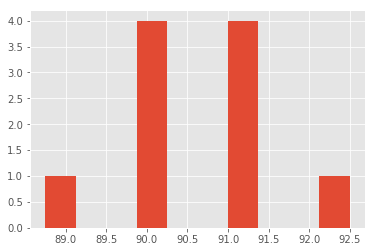

In [10]:
plt.hist(all_metrics)
plt.show()

In [11]:
print_results(research='model_est_1/', names=['test_mape30'], types_var=['metrics'], n_last=50)

╒════════════════════════╤═══════════════════╤═══════════════╕
│ params                 │   test_mape30 std │   test_mape30 │
╞════════════════════════╪═══════════════════╪═══════════════╡
│ '3', 'cna', '23', '64' │          0.757116 │        91.605 │
╘════════════════════════╧═══════════════════╧═══════════════╛


Average value (median): 91.9125

### 2d model evaluation

For model performance assessment an [experiment](./parameters_estimation_2d_model.ipynb) was conducted on 10 model training launches from  scratch.

Research results loading and a distribution for `test_mape30`:

In [12]:
res_table = Research().load('research_last_8/').load_results()
all_metrics = np.array(res_table[res_table['iteration']==1199][res_table['name']=='test_mape30']['metrics'], dtype=np.float32)

`Test_mape30` histogram

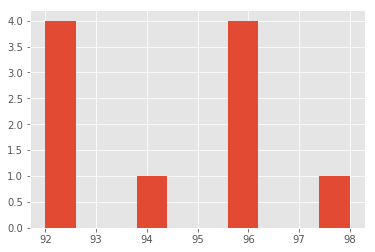

In [13]:
plt.hist(all_metrics)
plt.show()

In [14]:
print_results(research='research_last_8/', names=['test_mape30'], types_var=['metrics'], n_last=50)

╒══════════╤═══════════════╤═══════════════════╕
│   params │   test_mape30 │   test_mape30 std │
╞══════════╪═══════════════╪═══════════════════╡
│        8 │        91.932 │             0.564 │
╘══════════╧═══════════════╧═══════════════════╛


Average value (median) for the last 50 iterations: 91.82

## Summary
The model predicts a position of the radial mode according to the pressure derivative vs time data. The mean model metrics corresponding to a percentage of items with absolute percentage error less than 30% is 91.91% for the 1d model and 91.932 for the 2d model. One can see, that 2d model works better, than recommended to use this model in future experiments.

## Proposals for the improvement and further development

The following methods maybe can inpove the quality of the model:
* using sampling that depends on number of points in small area instead of uniform distribution
* change linear interpolation to another method of interpolation
* build an ensemble of models.